In [ ]:
import pandas 
df = pandas.read_csv("loan_data_cleaned.csv", sep='\t', encoding='utf-8')

In [18]:
import pandas as pd
df = pd.read_csv("loan.csv")

df=df.drop(['id','member_id','funded_amnt','funded_amnt_inv','sub_grade','int_rate','emp_title','issue_d','zip_code',
            'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
            'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','desc','url','title',
            'initial_list_status','pymnt_plan','policy_code','application_type','earliest_cr_line','last_credit_pull_d',
            'next_pymnt_d','addr_state'],axis=1)

df=df.dropna(thresh=len(df)/2,axis=1)
df=df.dropna()

def status_binary(text):
    if text=='Fully Paid':
        return 0
    elif text=='Current' or text=='Issued':
        return -1
    else:
        return 1
df['loan_status']=df['loan_status'].apply(status_binary)
df=df[df['loan_status']!=-1]

def purpose_class(text):
    if text=='debt_consolidation' or text=='credit_card':
        return 'refinance'
    elif text=='house' or text=='home_improvement' or text=='renewable_energy' or text=='moving':
        return 'home'
    elif text=='car' or text=='major_purchase':
        return 'major_purchase'
    else:
        return 'other'
df['purpose']=df['purpose'].apply(purpose_class)

dummy_df=pd.get_dummies(df[['home_ownership','verification_status','purpose','term']])
df=df.drop(['home_ownership','verification_status','purpose','term'],axis=1)
df=pd.concat([df,dummy_df],axis=1)

mapping_dict={
    'emp_length':{
        '10+ years':10,
        '9 years':9,
        '8 years':8,
        '7 years':7,
        '6 years':6,
        '5 years':5,
        '4 years':4,
        '3 years':3,
        '2 years':2,
        '1 year':1,
        '< 1 year':0,
        'n/a':0
    },
    'grade':{
        'A':1,
        'B':2,
        'C':3,
        'D':4,
        'E':5,
        'F':6,
        'G':7,
    }
}
df=df.replace(mapping_dict)

cols = list(df)
cols.insert(0, cols.pop(cols.index('loan_status')))
df = df.ix[:, cols]
df.head()

/home/louis/projects/LC_data/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/louis/projects/LC_data/.env/lib/python3.5/site-packages/ipykernel_launcher.py:67: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,loan_status,loan_amnt,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_home,purpose_major_purchase,purpose_other,purpose_refinance,term_ 36 months,term_ 60 months
42538,0,12000.0,407.40,2,10,40000.0,16.94,0.0,0.0,7.0,...,1,0,1,0,0,0,0,1,1,0
42544,0,3000.0,100.87,2,10,25000.0,24.68,0.0,0.0,5.0,...,1,0,0,1,0,0,0,1,1,0
42546,0,28000.0,872.52,1,5,325000.0,18.55,0.0,1.0,15.0,...,0,0,1,0,0,0,0,1,1,0
42549,0,24000.0,814.80,2,10,100000.0,22.18,0.0,0.0,14.0,...,0,0,0,1,0,0,0,1,1,0
42550,1,8000.0,261.88,2,2,33000.0,15.75,0.0,1.0,9.0,...,0,1,0,0,0,0,0,1,1,0


In [19]:
df['default'] = df['loan_status']
df = df.drop(columns='loan_status')
for k in df.keys():
    if df[k].max() > 1.5:
        df[k] = (df[k] - df[k].mean())/df[k].std()

In [20]:
from sklearn.cross_validation import train_test_split
df['not_default'] = 1 - df['default']
Xs = df.drop(columns=['default', 'not_default']).values
Ys = df[['default', 'not_default']].values*[5,1]
# Ys = df[['default']].values
# Xs = (Xs - Xs.mean())/Xs.std(axis=0)  # Normalize
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
# X_d = X_train[Y_train[:, 0] == 1]
# X_n = X_train[Y_train[:, 1] == 1]
# Y_d = Y_train[Y_train[:, 0] == 1]
# Y_n = Y_train[Y_train[:, 1] == 1]
# print(X_d.shape)
# print(X_n.shape)
# print(Y_d.shape)
# print(Y_n.shape)

(140830, 33)
(60357, 33)
(140830, 2)
(60357, 2)


In [21]:
!rm -r sess1/

In [22]:
import tensorflow as tf
tf.reset_default_graph()

In [23]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float64, [None, 33], name='x-input')
    y = tf.placeholder(tf.int64, [None, 2], name='y-input')

In [24]:
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.01, dtype=tf.float64)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.01, dtype=tf.float64)
    return tf.Variable(initial)

In [25]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [26]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations

In [27]:
# hidden1 = nn_layer(x, 44, 20, 'layer1', act=tf.nn.sigmoid)
# hidden2 = nn_layer(hidden1, 80, 20, 'layer2', act=tf.nn.sigmoid)
# pred = nn_layer(hidden1, 20, 2, 'layer3', act=tf.identity)

pred = nn_layer(x, 33, 2, 'layer1', act=tf.identity)

# with tf.name_scope('des'):
#     des = (tf.sign(pred)+1)/2
#     variable_summaries(des)
    
# with tf.name_scope('loss'):
#     loss = tf.reduce_mean(des*(tf.cast(y, tf.float64)*(-1)+(1-tf.cast(y, tf.float64))*0.1))
# tf.summary.scalar('loss', loss)

# with tf.name_scope('train'):
#     train_step = tf.train.AdamOptimizer(0.01).minimize(-loss)

with tf.name_scope('prob'):
    prob = tf.nn.softmax(pred)
    variable_summaries(prob)

with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [28]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(pred, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [29]:
merged = tf.summary.merge_all()

In [30]:
# with tf.device('/cpu:0'):
sess = tf.Session()
train_writer = tf.summary.FileWriter('./sess1/', sess.graph)
sess.run(tf.global_variables_initializer())
import numpy as np
import tqdm
import random
for i in tqdm.tqdm(range(10000)):
    idx = np.random.choice(np.arange(len(X_train)), 1000)
#     idx1 = np.random.choice(np.arange(len(X_d)), 1000)
#     idx2 = np.random.choice(np.arange(len(X_n)), 1000)
#     batch_Xs = np.concatenate((X_d[idx1], X_n[idx2]), axis=0)
#     batch_Ys = np.concatenate((Y_d[idx1], Y_n[idx2]), axis=0)
    batch_Xs = X_train[idx]
    batch_Ys = Y_train[idx]
    summary, _ = sess.run([merged, train_step], feed_dict={x: batch_Xs, y: batch_Ys})
#     if not i % 100:
#         print(sess.run([accuracy, cross_entropy], feed_dict={x: X_test, y: Y_test}))
    train_writer.add_summary(summary, i)

100%|██████████| 10000/10000 [00:21<00:00, 466.60it/s]


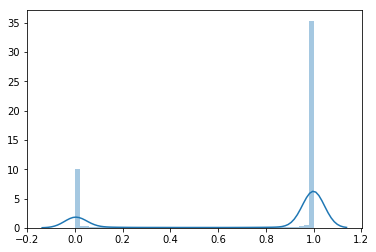

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p =sess.run(prob, feed_dict={x: X_test})
sns.distplot(p[:,0])

In [32]:
from sklearn.metrics import confusion_matrix
y_1, y_2 = sess.run([tf.argmax(y, 1), tf.argmax(pred, 1)], feed_dict={x: X_test, y: Y_test})
confusion_matrix(y_1, y_2)

array([[14122,  1576],
       [31474, 13185]])

In [33]:
from sklearn.metrics import confusion_matrix
y_1, y_2 = sess.run([tf.argmax(y, 1), tf.argmax(pred, 1)] , {x: X_train, y: Y_train})
confusion_matrix(y_1, y_2)

array([[33654,  3770],
       [72482, 30924]])

In [34]:
idx1 = np.random.choice(np.arange(len(Y_test[Y_test[:,1] == 0])), 10000)
idx2 = np.random.choice(np.arange(len(Y_test[Y_test[:,1] == 1])), 10000)

y_test_1 = Y_test[Y_test[:,1] == 0][idx1]
x_test_1 = X_test[Y_test[:,1] == 0][idx1]
y_test_2 = Y_test[Y_test[:,1] == 1][idx2]
x_test_2 = X_test[Y_test[:,1] == 1][idx2]

In [ ]:
np.concatenate([x_test_1, x_test_2])
np.concatenate([y_test_1, y_test_2])

In [ ]:
sess.run(accuracy, feed_dict={x: np.concatenate([x_test_1, x_test_2]), y: np.concatenate([y_test_1, y_test_2])})

In [31]:
Y_test[:,1].sum()

44659

In [30]:
14204+1494

15698